In [1]:
import qiskit.tools.jupyter

%qiskit_version_table

# Quantum Kernel Machine Learning

## Overview

The general task of machine learning is to find and study patterns in data. For many datasets, the datapoints are better understood in a higher dimensional feature space. This is the fundamental principle behind a series of machine learning algorithms known as *kernel methods*.

In this notebook, you will learn how to define quantum kernels using `qiskit-machine-learning` and how these can be plugged into different algorithms to solve classification and clustering problems.

All examples used in this tutorial are based on this reference paper: [_Supervised learning with quantum enhanced feature spaces_](https://arxiv.org/pdf/1804.11326.pdf).

The content is structured as follows:

1. [Introduction](#1.-Introduction)
2. [Classification](#2.-Classification)
3. [Clustering](#3.-Clustering)
4. [Kernel Principal Components Analysis](#4.-Kernel-Principal-Component-Analysis)
5. [Conclusion](#5.-Conclusion)

## 1. Introduction

### 1.1. Kernel Methods for Machine Learning

Kernel methods are a collection of pattern analysis algorithms that use kernel functions to operate in a high-dimensional feature space. The best-known application of kernel methods is in **Support Vector Machines (SVMs)**, supervised learning algorithms commonly used for classification tasks. The main goal of SVMs is to find decision boundaries to separate a given set of data points into classes. When these data spaces are not linearly separable, SVMs can benefit from the use of kernels to find these boundaries.

Formally, decision boundaries are hyperplanes in a high dimensional space. The kernel function implicitly maps input data into this higher dimensional space, where it can be easier to solve the initial problem. In other words, kernels may allow data distributions that were originally non-linearly separable to become a linearly separable problem. This is an effect known as the "kernel trick".

There are use-cases for kernel-based unsupervised algorithms too, for example, in the context of clustering. **Spectral Clustering** is a technique where data points are treated as nodes of a graph, and the clustering task is viewed as a graph partitioning problem where nodes are mapped to a space where they can be easily segregated to form clusters.

### 1.2. Kernel Functions

Mathematically, kernel functions follow:

$k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle$

where 
* $k$ is the kernel function
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $f$ is a map from $n$-dimension to $m$-dimension space and 
* $\langle a,b \rangle$ denotes the inner product

When considering finite data, a kernel function can be represented as a matrix: 

$K_{ij} = k(\vec{x}_i,\vec{x}_j)$.

### 1.3. Quantum Kernels

The main idea behind quantum kernel machine learning is to leverage quantum feature maps to perform the kernel trick. In this case, the quantum kernel is created by mapping a classical feature vector $\vec{x}$ to a Hilbert space using a quantum feature map $\phi(\vec{x})$. Mathematically:

$K_{ij} = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2}$

where 
* $K_{ij}$ is the kernel matrix
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $\phi(\vec{x})$ is the quantum feature map
* $\left| \langle a|b \rangle \right|^{2}$ denotes the overlap of two quantum states $a$ and $b$

Quantum kernels can be plugged into common classical kernel learning algorithms such as SVMs or clustering algorithms, as you will see in the examples below. They can also be leveraged in new quantum kernel methods like [QSVC](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.algorithms.QSVC.html) class  provided by `qiskit-machine-learning` which is explored in this tutorial, and other methods as shown in later tutorials on [Pegasos QSVC](07_pegasos_qsvc.ipynb) and [Quantum Kernel Training](08_quantum_kernel_trainer.ipynb).

***

Before introducing any example, we set up the global seed to ensure reproducibility:

In [2]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 12345

## 2. Classification

This section illustrates a quantum kernel classification workflow using `qiskit-machine-learning`.

### 2.1. Defining the dataset

For this example, we will use the _ad hoc dataset_ as described in the reference [paper](https://arxiv.org/pdf/1804.11326.pdf). 

We can define the dataset dimension and get our train and test subsets:

In [3]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

This dataset is two-dimensional, the two features are represented by the $x$ and $y$ coordinates, and it has two class labels: A and B. We can plot it and see what the distribution looks like. We define utility functions to plot the dataset.

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

Now we actually plot the dataset for classification:

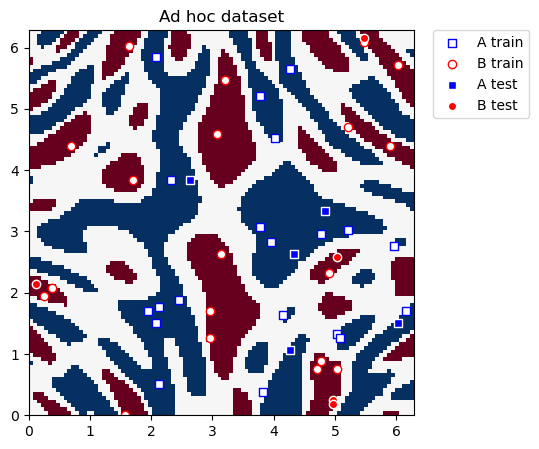

In [5]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

### 2.2. Defining the quantum kernel

The next step is to create a quantum kernel instance that will help classify this data. 

We use the [FidelityQuantumKernel](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.kernels.FidelityQuantumKernel.html) class, and pass two input arguments to its constructor: 

1. `feature_map`: in this case, a two-qubit [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html).

2. `fidelity`: in this case, the [ComputeUncompute](https://qiskit.org/ecosystem/algorithms/stubs/qiskit_algorithms.state_fidelities.ComputeUncompute.html) fidelity subroutine that leverages the [Sampler](https://qiskit.org/documentation/stubs/qiskit.primitives.Sampler.html) primitive.

**NOTE:** If you don't pass a `Sampler` or `Fidelity` instance, then the instances of the reference `Sampler` and `ComputeUncompute` classes (found in `qiskit.primitives`) will be created by default.

In [6]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

### 2.3. Classification with SVC
The quantum kernel can now be plugged into classical kernel methods, such as the [SVC](https://scikit-learn.org/stable/modules/svm.html) algorithm from `scikit-learn`. This algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways:

1. by providing the kernel as a **callable function**
2. by precomputing the **kernel matrix**

#### Kernel as a callable function

We define a SVC model and directly pass the `evaluate` function of the quantum kernel as a callable. Once the model is created, we train it by calling the `fit` method on the training dataset and evaluate the model for accuracy with `score`.

In [7]:
from sklearn.svm import SVC

adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

adhoc_svc.fit(train_features, train_labels)

adhoc_score_callable_function = adhoc_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

Callable kernel classification test score: 1.0


#### Precomputed kernel matrix

Instead of passing a function of the quantum kernel as a callable, we can also precompute training and testing kernel matrices before passing them to the `scikit-learn` `SVC` algorithm. 

To extract the train and test matrices, we can call `evaluate` on the previously defined kernel and visualize them graphically as follows:

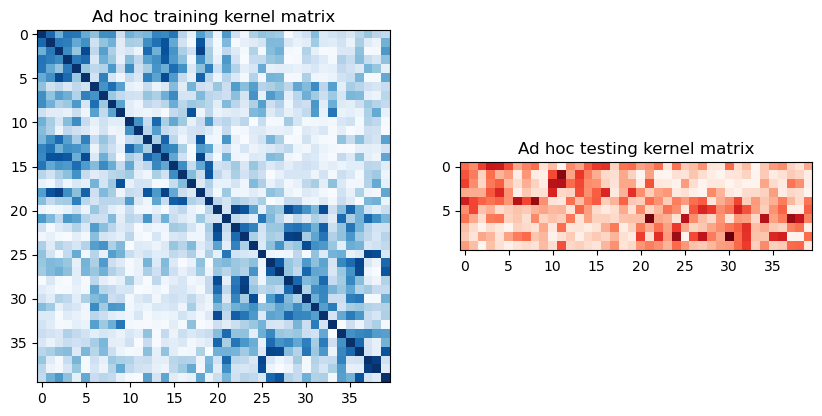

In [8]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

To use these matrices, we set the `kernel` parameter of a new `SVC` instance to `"precomputed"`. We train the classifier by calling `fit` with the training matrix and training dataset. Once the model is trained, we evaluate it using the test matrix on the test dataset.

In [9]:
adhoc_svc = SVC(kernel="precomputed")

adhoc_svc.fit(adhoc_matrix_train, train_labels)

adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


### 2.4. Classification with QSVC

`QSVC` is an alternative training algorithm provided by `qiskit-machine-learning` for convenience. It is an extension of `SVC` that takes in a quantum kernel instead of the `kernel.evaluate` method shown before.

In [10]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


### 2.5. Evaluation of models used for classification

In [11]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {adhoc_score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {adhoc_score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

Classification Model                    | Accuracy Score
---------------------------------------------------------
SVC using kernel as a callable function |       1.00
SVC using precomputed kernel matrix     |       1.00
QSVC                                    |       1.00


As the classification dataset is small, we find that the three models achieve 100% accuracy.

## 3. Clustering

The second workflow in this tutorial focuses on a clustering task using `qiskit-machine-learning` and the spectral clustering algorithm from `scikit-learn`.

### 3.1. Defining the dataset

We will once again use the _ad hoc dataset_, but now generated with a higher gap of `0.6` (previous example: `0.3`) between the two classes. 

Note that clustering falls under the category of unsupervised machine learning, so a test dataset is not required.

In [12]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=25,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

 We plot the clustering dataset below:

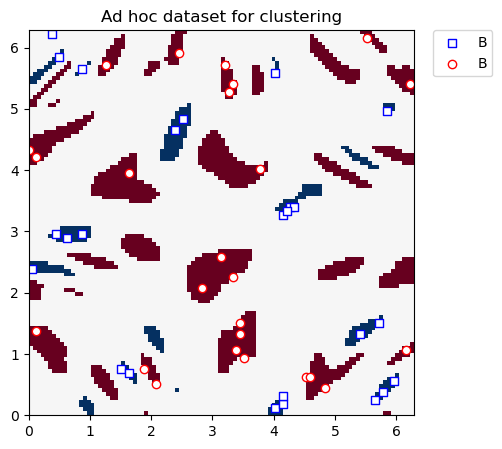

In [13]:
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

# A label plot
plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "B")

# B label plot
plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for clustering")

plt.show()

### 3.2. Defining the Quantum Kernel
We use an identical setup as in the classification example. We create another instance of the `FidelityQuantumKernel` class with a `ZZFeatureMap`, but you might notice that in this case we do not provide a `fidelity` instance. This is because the `ComputeUncompute` method provided in the previous case is instantiated by default when the fidelity instance is not provided explicitly. 

In [14]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

adhoc_kernel = FidelityQuantumKernel(feature_map=adhoc_feature_map)

### 3.3. Clustering with the Spectral Clustering Model

The `scikit-learn` spectral clustering algorithm allows us to define a custom kernel in two ways (just like `SVC`):

1. by providing the kernel as a **callable function**
2. by precomputing the **kernel matrix**. 

With the current `FidelityQuantumKernel` class in `qiskit-machine-learning`, we can only use the latter option, so we precompute the kernel matrix by calling `evaluate` and visualize it as follows:

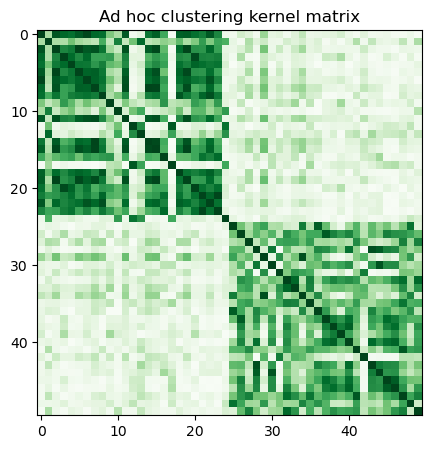

In [15]:
adhoc_matrix = adhoc_kernel.evaluate(x_vec=train_features)

plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(adhoc_matrix), interpolation="nearest", origin="upper", cmap="Greens")
plt.title("Ad hoc clustering kernel matrix")
plt.show()

Next, we define a spectral clustering model and fit it using the precomputed kernel. Further, we score the labels using normalized mutual information, since we know the class labels a priori (before hand).

In [16]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

adhoc_spectral = SpectralClustering(2, affinity="precomputed")

cluster_labels = adhoc_spectral.fit_predict(adhoc_matrix)

cluster_score = normalized_mutual_info_score(cluster_labels, train_labels)

print(f"Clustering score: {cluster_score}")

Clustering score: 0.7287008798015754


## 4. Kernel Principal Component Analysis

This section focuses on a Principal Component Analysis task using a kernel PCA algorithm. We calculate a kernel matrix using a `ZZFeatureMap` and show that this approach translates the original features into a new space, where axes are chosen along principal components. In this space the classification task can be performed with a simpler model rather than an SVM.

### 4.1. Defining the dataset

We again use the _ad hoc dataset_ with a gap of `0.6` between the two classes. This dataset resembles the dataset we had in the clustering section, the difference is that in this case `test_size` is not zero.

In [17]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=25,
    test_size=10,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

We plot the training and test datasets below. Our ultimate goal in this section is to construct new coordinates where the two classes can be linearly separated.

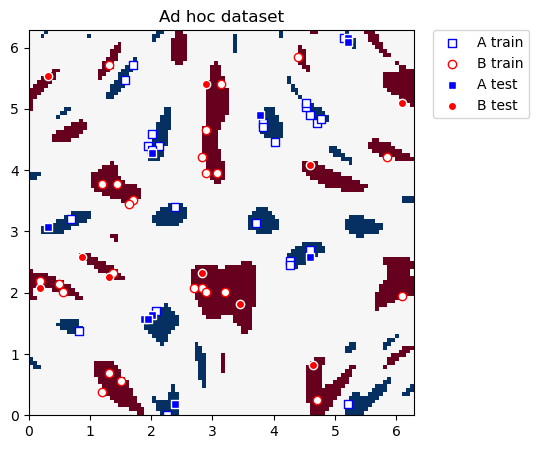

In [18]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

### 4.2. Defining the Quantum Kernel

We proceed with the same kernel setup as it was in the classification task, namely a `ZZFeatureMap` circuit as a feature map and an instance of `FidelityQuantumKernel`.

In [19]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")
qpca_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

Then, we evaluate kernel matrices for the training and test features.

In [20]:
matrix_train = qpca_kernel.evaluate(x_vec=train_features)
matrix_test = qpca_kernel.evaluate(x_vec=test_features, y_vec=train_features)

### 4.3. Comparison of Kernel PCA on gaussian and quantum kernel

In this section we use the `KernelPCA` implementation from `scikit-learn`, with the `kernel` parameter set to "rbf" for a gaussian kernel and "precomputed" for a quantum kernel. The former is very popular in classical machine learning models, whereas the latter allows using a quantum kernel defined as `qpca_kernel`.

One can observe that the gaussian kernel based Kernel PCA model fails to make the dataset linearly separable, while the quantum kernel succeeds.

While usually PCA is used to reduce the number of features in a dataset, or in other words to reduce dimensionality of a dataset, we don't do that here. Rather we keep the number of dimensions and employ the kernel PCA, mostly for visualization purposes, to show that classification on the transformed dataset becomes easily tractable by linear methods, like logistic regression. We use this method to separate two classes in the principal component space with a `LogisticRegression` model from `scikit-learn`. As usual we train it by calling the `fit` method on the training dataset and evaluate the model for accuracy with `score`.

In [21]:
from sklearn.decomposition import KernelPCA

kernel_pca_rbf = KernelPCA(n_components=2, kernel="rbf")
kernel_pca_rbf.fit(train_features)
train_features_rbf = kernel_pca_rbf.transform(train_features)
test_features_rbf = kernel_pca_rbf.transform(test_features)

kernel_pca_q = KernelPCA(n_components=2, kernel="precomputed")
train_features_q = kernel_pca_q.fit_transform(matrix_train)
test_features_q = kernel_pca_q.transform(matrix_test)

Here we train and score a model.

In [22]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()
logistic_regression.fit(train_features_q, train_labels)

logistic_score = logistic_regression.score(test_features_q, test_labels)
print(f"Logistic regression score: {logistic_score}")

Logistic regression score: 0.95


Let's plot the results. First, we plot the transformed dataset we get with the quantum kernel. On the same plot we also add model results. Then, we plot the transformed dataset we get with the gaussian kernel.

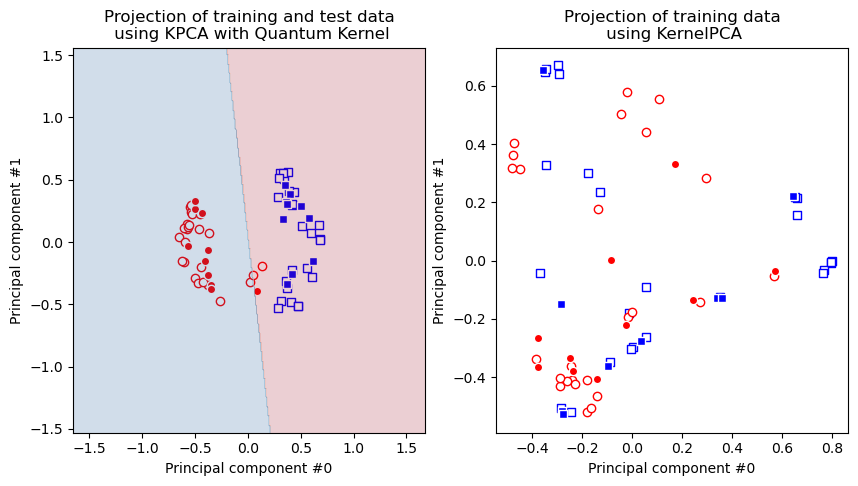

In [23]:
fig, (q_ax, rbf_ax) = plt.subplots(1, 2, figsize=(10, 5))


plot_features(q_ax, train_features_q, train_labels, 0, "s", "w", "b", "A train")
plot_features(q_ax, train_features_q, train_labels, 1, "o", "w", "r", "B train")

plot_features(q_ax, test_features_q, test_labels, 0, "s", "b", "w", "A test")
plot_features(q_ax, test_features_q, test_labels, 1, "o", "r", "w", "A test")

q_ax.set_ylabel("Principal component #1")
q_ax.set_xlabel("Principal component #0")
q_ax.set_title("Projection of training and test data\n using KPCA with Quantum Kernel")

# Plotting the linear separation
h = 0.01  # step size in the mesh

# create a mesh to plot in
x_min, x_max = train_features_q[:, 0].min() - 1, train_features_q[:, 0].max() + 1
y_min, y_max = train_features_q[:, 1].min() - 1, train_features_q[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

predictions = logistic_regression.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
predictions = predictions.reshape(xx.shape)
q_ax.contourf(xx, yy, predictions, cmap=plt.cm.RdBu, alpha=0.2)

plot_features(rbf_ax, train_features_rbf, train_labels, 0, "s", "w", "b", "A train")
plot_features(rbf_ax, train_features_rbf, train_labels, 1, "o", "w", "r", "B train")
plot_features(rbf_ax, test_features_rbf, test_labels, 0, "s", "b", "w", "A test")
plot_features(rbf_ax, test_features_rbf, test_labels, 1, "o", "r", "w", "A test")

rbf_ax.set_ylabel("Principal component #1")
rbf_ax.set_xlabel("Principal component #0")
rbf_ax.set_title("Projection of training data\n using KernelPCA")
plt.show()

As we can see, the data points on the right figure are not separable, but they are on the left figure, hence in case of quantum kernel we can apply linear models on the transformed dataset and this is why SVM classifier works perfectly well on the _ad hoc_ dataset as we saw in the [classification section](#2.-Classification).

## 5. Conclusion

In this tutorial:

* We reviewed the fundamentals of quantum kernel learning
* We understood how to define quantum kernels as instances of `FidelityQuantumKernel`
* We learned how to use the `scikit-learn` `SVC` algorithm with a custom quantum kernel as a callable function vs precomputed quantum kernel matrix for classification
* We learned how to train classifiers with the `QSVC` algorithm from `qiskit-machine-learning`
* We learned how to use the `scikit-learn` `SpectralClustering` algorithms with a precomputed quantum kernel matrix for clustering
* We investigated how to plug in a quantum kernel into `scikit-learn`'s `KernelPCA` algorithm and transform the ad-hoc dataset into a new one that can be tackled by a linear model.

For further reference, `scikit-learn` has other algorithms that can use a precomputed kernel matrix, such as:

- [Agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)
- [Support vector regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
- [Ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
- [Gaussian process regression](https://scikit-learn.org/stable/modules/gaussian_process.html)

# Quantum Kernel Training for Machine Learning Applications

In this tutorial, we will train a quantum kernel on a labeled dataset for a machine learning application. To illustrate the basic steps, we will use Quantum Kernel Alignment (QKA) for a binary classification task. QKA is a technique that iteratively adapts a parametrized quantum kernel to a dataset while converging to the maximum SVM margin. More information about QKA can be found in the preprint, ["Covariant quantum kernels for data with group structure."](https://arxiv.org/abs/2105.03406)


The entry point to training a quantum kernel is the `QuantumKernelTrainer` class. The basic steps are:

1. Prepare the dataset
2. Define the quantum feature map
3. Set up an instance of `TrainableKernel` and `QuantumKernelTrainer` objects
4. Use the `QuantumKernelTrainer.fit` method to train the kernel parameters on the dataset
5. Pass the trained quantum kernel to a machine learning model

### Import Local, External, and Qiskit Packages and define a callback class for our optimizer

In [24]:
# External imports
from pylab import cm
from sklearn import metrics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data


class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

### Prepare the Dataset

In this guide, we will use Qiskit Machine Learning's `ad_hoc.py` dataset to demonstrate the kernel training process. See the documentation [here](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.datasets.ad_hoc_data.html).

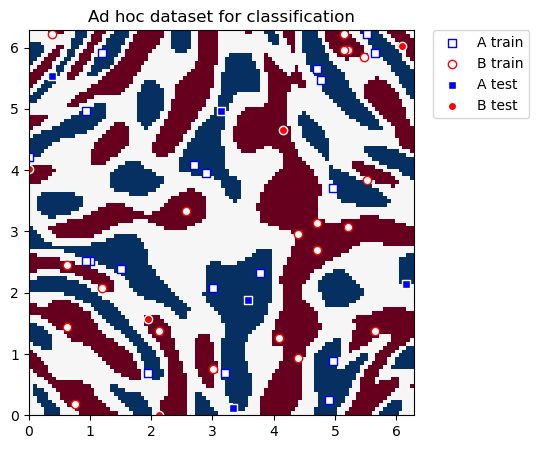

In [25]:
adhoc_dimension = 2
X_train, y_train, X_test, y_test, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    X_train[np.where(y_train[:] == 0), 0],
    X_train[np.where(y_train[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    X_train[np.where(y_train[:] == 1), 0],
    X_train[np.where(y_train[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)
plt.scatter(
    X_test[np.where(y_test[:] == 0), 0],
    X_test[np.where(y_test[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)
plt.scatter(
    X_test[np.where(y_test[:] == 1), 0],
    X_test[np.where(y_test[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")

plt.show()

### Define the Quantum Feature Map

Next, we set up the quantum feature map, which encodes classical data into the quantum state space. Here, we use a `QuantumCircuit` to set up a trainable rotation layer and a `ZZFeatureMap` from `Qiskit` to represent the input data.

In [26]:
# Create a rotational layer to train. We will rotate each qubit the same amount.
training_params = ParameterVector("θ", 1)
fm0 = QuantumCircuit(2)
fm0.ry(training_params[0], 0)
fm0.ry(training_params[0], 1)

# Use ZZFeatureMap to represent input data
fm1 = ZZFeatureMap(2)

# Create the feature map, composed of our two circuits
fm = fm0.compose(fm1)

fm.draw('mpl')
print(f"Trainable parameters: {training_params}")

Trainable parameters: θ, ['θ[0]']


### Set Up the Quantum Kernel and Quantum Kernel Trainer

To train the quantum kernel, we will use an instance of `TrainableFidelityQuantumKernel` (holds the feature map and its parameters) and `QuantumKernelTrainer` (manages the training process).

We will train using the Quantum Kernel Alignment technique by selecting the kernel loss function, `SVCLoss`, as input to the `QuantumKernelTrainer`. Since this is a Qiskit-supported loss, we can use the string, `"svc_loss"`; however, note that default settings are used when passing the loss as a string. For custom settings, instantiate explicitly with the desired options, and pass the `KernelLoss` object to the `QuantumKernelTrainer`.

We will select SPSA as the optimizer and initialize the trainable parameter with the `initial_point` argument. Note: The length of the list passed as the `initial_point` argument must equal the number of trainable parameters in the feature map.

In [27]:
# Instantiate quantum kernel
quant_kernel = TrainableFidelityQuantumKernel(feature_map=fm, training_parameters=training_params)

# Set up the optimizer
cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)

# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
)

### Train the Quantum Kernel

To train the quantum kernel on the dataset (samples and labels), we call the `fit` method of `QuantumKernelTrainer`.

The output of `QuantumKernelTrainer.fit` is a `QuantumKernelTrainerResult` object. The results object contains the following class fields:

 - `optimal_parameters`: A dictionary containing {parameter: optimal value} pairs
 - `optimal_point`: The optimal parameter value found in training
 - `optimal_value`: The value of the loss function at the optimal point
 - `optimizer_evals`: The number of evaluations performed by the optimizer
 - `optimizer_time`: The amount of time taken to perform optimization
 - `quantum_kernel`: A `TrainableKernel` object with optimal values bound to the feature map

In [28]:
# Train the kernel using QKT directly
qka_results = qkt.fit(X_train, y_train)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

{   'optimal_circuit': None,
    'optimal_parameters': {ParameterVectorElement(θ[0]): 1.6064813661025532},
    'optimal_point': array([1.60648137]),
    'optimal_value': 14.713139666717694,
    'optimizer_evals': 30,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7f35ec586130>}


### Fit and Test the Model

We can pass the trained quantum kernel to a machine learning model, then fit the model and test on new data. Here, we will use Qiskit Machine Learning's `QSVC` for classification.

In [29]:
# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC
qsvc.fit(X_train, y_train)

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.9


### Visualize the Kernel Training Process

From the callback data, we can plot how the loss evolves during the training process. We see it converges rapidly and reaches high test accuracy on this dataset with our choice of inputs.

We can also display the final kernel matrix, which is a measure of similarity between the training samples.

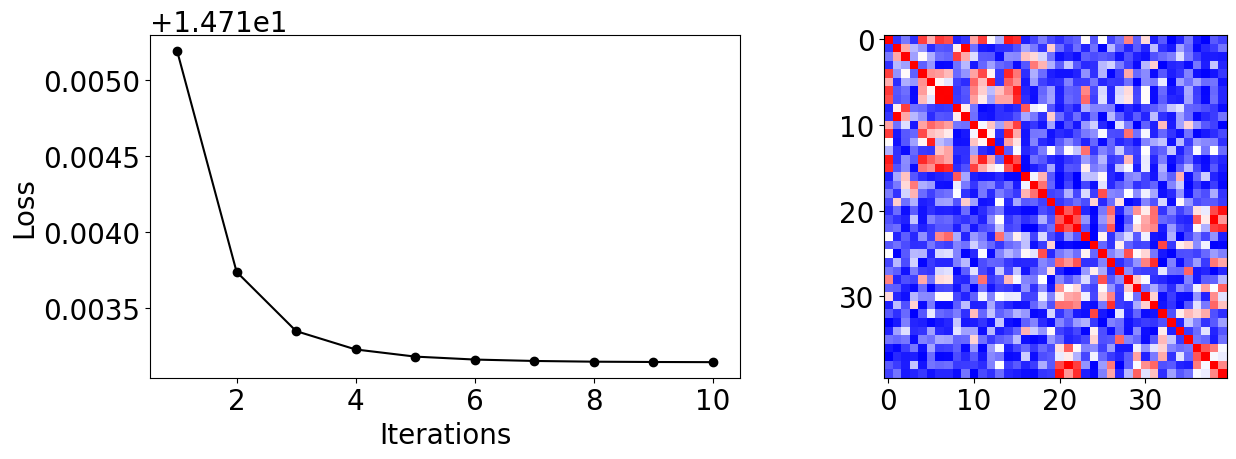

In [30]:
plot_data = cb_qkt.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=matplotlib.colormaps["bwr"])
fig.tight_layout()
plt.show()

In [31]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright

## How To Create Custom Kernel Loss Functions

In this guide, we show how to create custom kernel loss functions for quantum kernel training. This is useful if we desire the resulting kernel exhibit certain properties such as low rank, or high generalization to unseen data when used for classification. For this purpose, one may wish to evaluate a kernel on some dataset, $X$, and compute properties of the resulting kernel matrix, $K$, or optimize quantities related to the model weights of a [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) that has been trained using $K$. 

In order to ensure compatibility with Qiskit's optimizers, it is neccesary that kernel loss functions follow the following input-output behavior:

- A kernel loss function must take as input a single array of trainable parameter values 
- A kernel loss function must return a real number

Despite these constraints, the data, labels, `TrainableFidelityQuantumKernel` object, and any other necessary inputs must be made available to the kernel loss's internal logic. Below we suggest two approaches:

1. Provide all inputs to kernel loss as class variables
2. Wrap kernel loss function using `partial`


In [32]:
from functools import partial
from typing import Sequence

import numpy as np
import matplotlib.pyplot as plt

# Import Qiskit packages
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.utils.loss_functions import KernelLoss

Let's start by setting up a quantum kernel, data, and labels.

In [33]:
feature_map = ZZFeatureMap(3)
user_params = [feature_map.parameters[1]]

qkernel = TrainableFidelityQuantumKernel(
    feature_map=feature_map,
    training_parameters=user_params,
)

X_train = [[0.6, 0.2], [0.5, 0.3], [0.3, 0.7], [0.1, 0.5]]
y_train = np.array([0, 0, 1, 1])

### Option 1: Provide all inputs to kernel loss as class variables

The preferred option for building a custom kernel loss function is to mimic the structure of Qiskit's pre-defined kernel loss functions, such as `SVCLoss`. 

In order to match the behavior of existing kernel loss methods, your class should:
- Extend `KernelLoss` 
- Accept `kwargs` in the constructor
- Include a `evaluate` method that takes all neccesary inputs and returns the evaluated loss
- Include a `get_variational_callable` method that wraps `evaluate` with all inputs except the trainable parameter values `user_param_values`


In [34]:
class CustomKernelLoss(KernelLoss):
    """Example Kernel Loss class"""

    def __init__(self, **kwargs):
        self.kwargs = kwargs

    # Evaluate the Loss of a trainable quantum kernel
    # at a particular setting of user_param_values on
    # a particular dataset.
    def evaluate(
        self,
        parameter_values: Sequence[float],
        quantum_kernel: TrainableFidelityQuantumKernel,
        data: np.ndarray,
        labels: np.ndarray,
    ):
        # Bind the user parameter values
        quantum_kernel.assign_training_parameters(parameter_values)
        kernel_matrix = quantum_kernel.evaluate(data)
        return labels.T @ kernel_matrix @ labels

    # Wrap our evaluate method so to produce a callable
    # which maps user_param_values to loss scores.
    def get_variational_callable(
        self,
        quantum_kernel: TrainableFidelityQuantumKernel,
        data: np.ndarray,
        labels: np.ndarray,
    ):
        return partial(
            self.evaluate, quantum_kernel=quantum_kernel, data=data, labels=labels
        )


kernel_loss = CustomKernelLoss().get_variational_callable(qkernel, X_train, y_train)
print(kernel_loss([0.75]))

2.0828564856510017


We now have a black box callable that assigns a numeric value to any set of user parameter bindings. 

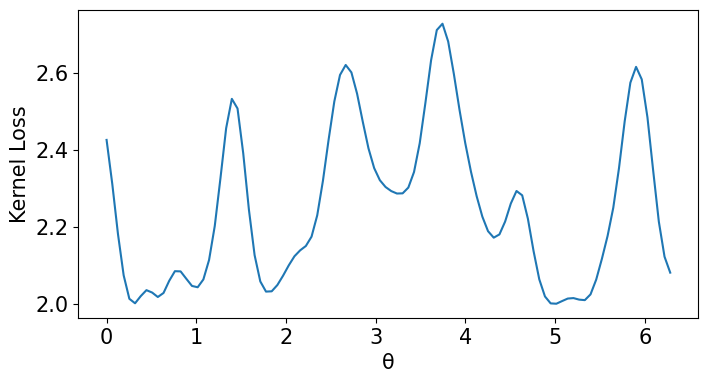

In [35]:
NUM_GRID_POINTS = 100
loss_values = [kernel_loss([val]) for val in np.linspace(0, 2 * np.pi, NUM_GRID_POINTS)]

plt.rcParams["font.size"] = 15
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, 2 * np.pi, NUM_GRID_POINTS), loss_values)
plt.xlabel("θ")
plt.ylabel("Kernel Loss")
plt.show()

### Option 2: Define kernel loss as a method and wrap with `partial`
If you do not wish to define a full class for your kernel loss (e.g., to minimize lines of code), you are always free to define your kernel loss as a standalone function that is then wrapped with `partial` to enforce the expected input/output behavior. Note that if your inputs are defined within scope of your kernel loss method, you can actually avoid using `partial`; however, this will often not be feasible in practice. 

In [36]:
def kernel_loss_full(training_param_values, kernel, data, labels):
    kernel.assign_training_parameters(training_param_values)
    kernel_matrix = kernel.evaluate(data)
    return labels.T @ kernel_matrix @ labels


kernel_loss = partial(kernel_loss_full, kernel=qkernel, data=X_train, labels=y_train)
print(kernel_loss([0.75]))

2.0828564856510017


In [37]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright

## How To Create Custom Quantum Feature Maps

In machine learning, a feature map represents a transformation of data into a higher-dimensional space. However, this can be an expensive computation. Instead, kernel functions can be used to implicitly encode this transformation through the pairwise inner products of data samples. Kernels are a similarity measure over the dataset and are a key component of many machine learning models, for example, support vector machines. A quantum computer can be used to encode classical data into the quantum state space. We call this a quantum feature map. 

In this guide, we will show how to create a custom quantum feature map with trainable parameters, which may be used as input to Qiskit machine learning algorithms such as `QSVC` and `QuantumKernelTrainer`. We will follow four basic steps:

1. Import required Qiskit packages
2. Design the circuit for the quantum feature map
3. Build the circuit with Qiskit
4. Implement the feature map as a `QuantumCircuit` child class

### Import Required Packages

To create a quantum feature map with trainable parameters in Qiskit, there are two basic guidelines.<br>
The quantum feature map should:
 - Be an extension of Qiskit's `QuantumCircuit` class
 - Contain some number of trainable user parameters, `θ`, in addition to parameters designated to input data, `x`

In [38]:
from typing import List, Callable, Union

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector



### Design the Circuit
Similarly to classical feature engineering, creating a quantum feature map is a process that strongly depends on the learning problem at hand. In general, we cannot suggest an optimal feature map with no prior knowledge of the learning problem. Instead, we will focus on the basic steps to create a circuit using the Qiskit API. To illustrate, we will build a version of the [covariant feature map](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/qkt/feature_maps/covariant_feature_map.py), which is tailored to a dataset with a particular structure. Check out [this guide](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/background/qkernels_and_data_w_group_structure.ipynb) for more information on covariant quantum kernels.

For this example, the feature map will be built from a circuit containing trainable parameters `θ` followed by a circuit encoding the input data `x`. The trainable parameter of the $i$th qubit corresponds to a rotation around the $y$-axis by an angle `θ[i]`. We follow this by an entanglement layer of controlled-$z$ gates. Finally, we encode two features `x[i], x[i+1]` per qubit using consecutive rotations around the $x$ and $z$ axes.   

### Build the Circuit with Qiskit

First, we instantiate a `QuantumCircuit`  and create the circuit layer with trainable parameters `θ[i]`. Here, we will assume we are given a dataset with 12 features and we encode two features per qubit.

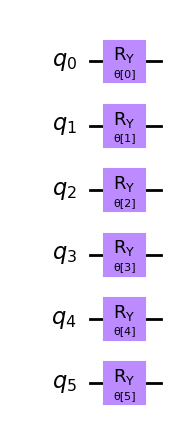

In [39]:
# For a dataset with 12 features; and 2 features per qubit
FEATURE_DIMENSION = 12
NUM_QUBITS = int(FEATURE_DIMENSION / 2)

# Qiskit feature maps should generally be QuantumCircuits or extensions of QuantumCircuit
feature_map = QuantumCircuit(NUM_QUBITS)
user_params = ParameterVector("θ", NUM_QUBITS)

# Create circuit layer with trainable parameters
for i in range(NUM_QUBITS):
    feature_map.ry(user_params[i], feature_map.qubits[i])

feature_map.draw('mpl')

Next, we will define an entanglement scheme (a linear map of controlled-$z$ gates) and create the entanglement layer.

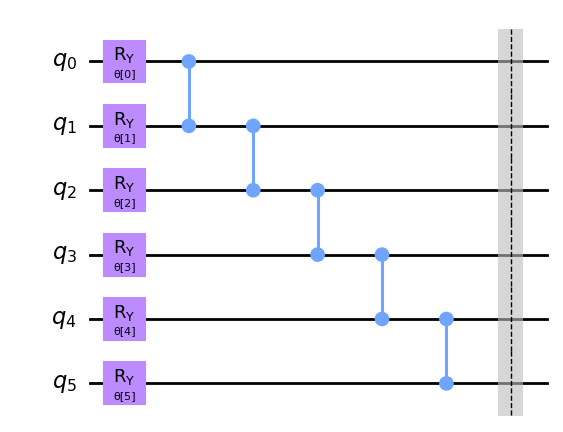

In [40]:
# Linear entanglement
entanglement = [[i, i + 1] for i in range(NUM_QUBITS - 1)]

for source, target in entanglement:
    feature_map.cz(feature_map.qubits[source], feature_map.qubits[target])

feature_map.barrier()

feature_map.draw('mpl')

Finally, we encode two features `x[i], x[i+1]` per qubit using a layer of single-qubit rotations.

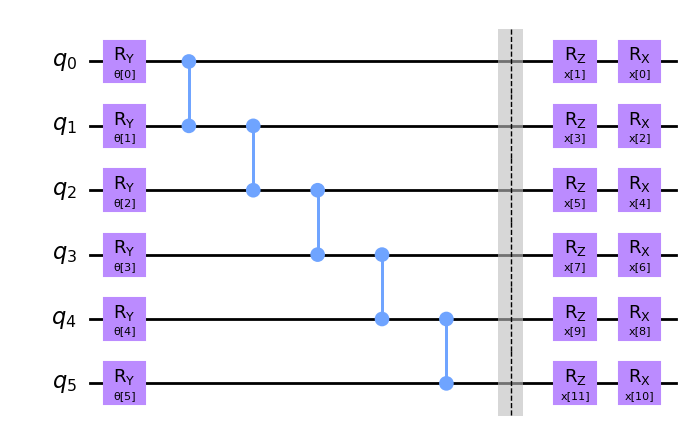

In [41]:
input_params = ParameterVector("x", FEATURE_DIMENSION)
for i in range(NUM_QUBITS):
    feature_map.rz(input_params[2 * i + 1], feature_map.qubits[i])
    feature_map.rx(input_params[2 * i], feature_map.qubits[i])

feature_map.draw('mpl')

### Implement the Feature Map as a `QuantumCircuit` Child Class

Most Qiskit algorithms that take feature maps as input require the feature map be a class extension of a `QuantumCircuit`. While there are many ways to do this, we suggest the following approach illustrated with `ExampleFeatureMap` that extends `QuantumCircuit`:

The feature map circuit is created upon instantiation such that
 - Parameters such as feature dimension and entanglement scheme should be specified during initialization
 - In the initialization, `QuantumCircuit.__init__()` is called before the feature map circuit is generated, which ensures all `QuantumCircuit` class fields (e.g. `QuantumCircuit.qubits`) are properly initialized
 - After the `QuantumCircuit` constructor has been called, a class method `_generate_feature_map` generates the feature map circuit

In [42]:
class ExampleFeatureMap(QuantumCircuit):
    """The Example Feature Map circuit"""

    def __init__(
        self,
        feature_dimension: int,
        entanglement: Union[str, List[List[int]], Callable[[int], List[int]]] = None,
        name: str = "ExampleFeatureMap",
    ) -> None:
        """Create a new Example Feature Map circuit.
        Args:
            feature_dimension: The number of features
            entanglement: Entanglement scheme to be used in second layer
            name: Name of QuantumCircuit object

        Raises:
            ValueError: ExampleFeatureMap requires an even number of input features
        """
        if (feature_dimension % 2) != 0:
            raise ValueError(
                """
            Example feature map requires an even number of input features.
                """
            )
        self.feature_dimension = feature_dimension
        self.entanglement = entanglement
        self.training_parameters = None

        # Call the QuantumCircuit initialization
        num_qubits = feature_dimension / 2
        super().__init__(
            num_qubits,
            name=name,
        )

        # Build the feature map circuit
        self._generate_feature_map()

    def _generate_feature_map(self):
        # If no entanglement scheme specified, use linear entanglement
        if self.entanglement is None:
            self.entanglement = [[i, i + 1] for i in range(self.num_qubits - 1)]

        # Vector of data parameters
        input_params = ParameterVector("x", self.feature_dimension)

        training_params = ParameterVector("θ", self.num_qubits)
        # Create an initial rotation layer of trainable parameters
        for i in range(self.num_qubits):
            self.ry(training_params[i], self.qubits[i])

        self.training_parameters = training_params

        # Create the entanglement layer
        for source, target in self.entanglement:
            self.cz(self.qubits[source], self.qubits[target])

        self.barrier()

        # Create a circuit representation of the data group
        for i in range(self.num_qubits):
            self.rz(input_params[2 * i + 1], self.qubits[i])
            self.rx(input_params[2 * i], self.qubits[i])

### Instantiate and Inspect the Example Feature Map

Finally, we will instantiate and inspect an `ExampleFeatureMap` object. We will use `feature_dimension=10` and the default linear entanglement, which should produce a 5-qubit feature map circuit.

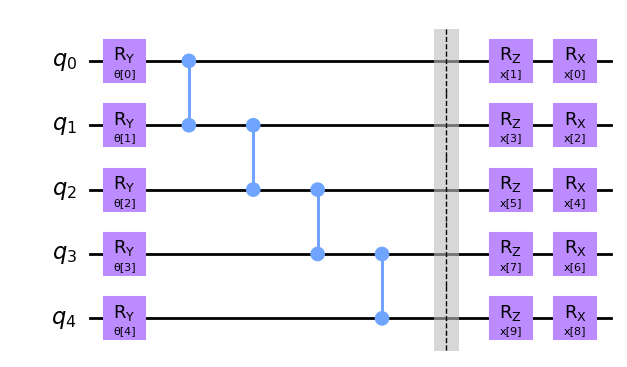

In [43]:
feature_map = ExampleFeatureMap(feature_dimension=10)
feature_map.draw('mpl')

## How To Assign Training Parameters to a Quantum Kernel

In this guide, we show the ins and outs of assigning training parameters to a `TrainableKernel` instance using Qiskit Machine Learning. 

We can create a `TrainableFidelityQuantumKernel` (`QK`) and specify our feature map and trainable parameters. This can be done at initialization by passing an array of `Parameters` as the `training_parameters` argument to the `QK` constructor.

After the `QK.training_parameters` field has been set, `QK.assign_training_parameters()` offers two ways to assign values to the training parameters

1. Bind training parameters using a dictionary
    - Keys to dict must be parameters within the feature map and must exist in `QK.training_parameters`
    - Values in dict may be either numerical assignments or `ParameterExpression` objects
2. Bind user parameters using a list of values
    - If binding using a list of values, the list must be of same size and ordering as `QK.training_parameters`. Each input value will be bound to its corresponding ``training_parameters`` value.
     
We begin by importing a few packages and instantiating a feature map circuit with three trainable parameters, `θ`, and three input parameters, `x`.

In [44]:
# pylint: disable=import-error, wrong-import-position, pointless-statement
import os
import sys
import numpy as np

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel

input_params: x, ['x[0]', 'x[1]', 'x[2]']
training_params: θ, ['θ[0]', 'θ[1]', 'θ[2]']


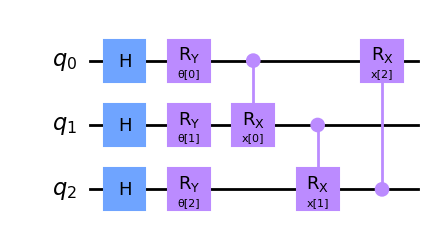

In [45]:
NUM_QUBITS = 3
fm = QuantumCircuit(NUM_QUBITS)
input_params = ip = ParameterVector("x", NUM_QUBITS)
training_params = tp = ParameterVector("θ", NUM_QUBITS)

for i in range(NUM_QUBITS):
    fm.h(i)
    fm.ry(tp[i], i)

for i in range(NUM_QUBITS):
    fm.crx(ip[i], (i) % NUM_QUBITS, (i + 1) % NUM_QUBITS)

# Define a Quantum Kernel using our trainable feature map
qk = TrainableFidelityQuantumKernel(
    feature_map=fm, training_parameters=training_params[:NUM_QUBITS]
)

print("input_params:", input_params)
print("training_params:", training_params)
qk.feature_map.draw('mpl')

### Option  1: Bind User Parameters with a Dictionary

Here, we will use a dictionary of the form `{Parameter : Value}` that maps training parameters to either numeric values or `ParameterExpression` objects.

In [46]:
# Bind parameters to numeric values
param_binds = {tp[0]: np.pi / 2, tp[1]: np.pi / 3, tp[2]: np.pi / 4}

qk.assign_training_parameters(param_binds)
qk.parameter_values

array([1.57079633, 1.04719755, 0.78539816])

We are free to bind a subset of our training parameters and re-bind parameters to new values.

In [47]:
# Create incomplete training param bindings
param_binds = {tp[0]: np.pi / 6, tp[1]: np.pi / 5}

qk.assign_training_parameters(param_binds)
qk.parameter_values

array([0.52359878, 0.62831853, 0.78539816])

We can  un-bind our training parameters or assign training parameters to different `ParameterExpression` objects. This is done in in the same way that we would bind numeric values. 

In [48]:
# Create incomplete user param bindings
param_binds = {tp[0]: tp[0], tp[1]: tp[0] + tp[2], tp[2]: tp[2]}

qk.assign_training_parameters(param_binds)
qk.parameter_values

array([ParameterVectorElement(θ[0]), ParameterExpression(θ[0] + θ[2]),
       ParameterVectorElement(θ[2])], dtype=object)

### Option 2: Bind Training Parameters with a List

If the `training_parameters` have been specified in the `QuantumKernel`, we may bind and unbind those parameters using only lists of parameter values. Note that the list of values must always be equal in size to the `QuantumKernel.training_parameters` array, and the values will be assigned in order.

Here we instantiate a new quantum kernel with the three training parameters unbound.

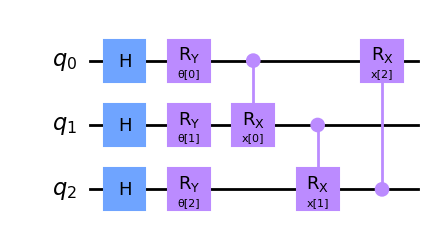

In [49]:
qk = TrainableFidelityQuantumKernel(feature_map=fm, training_parameters=training_params)
qk.feature_map.draw('mpl')

We may want to assign numerical values to parameters 0 and 2, while leaving parameter 1 unchanged.

In [50]:
param_values = [np.pi / 7, tp[1], np.pi / 9]
qk.assign_training_parameters(param_values)
qk.parameter_values

array([0.4487989505128276, ParameterVectorElement(θ[1]),
       0.3490658503988659], dtype=object)

To assign parameter 1 to a numerical value, while leaving parameters 0 and 2 unchaged, we pass in a full list of the new values (values 0 and 2 will remain the same.)

In [51]:
param_values = [np.pi / 7, np.pi / 6, np.pi / 9]
qk.assign_training_parameters(param_values)
qk.parameter_values

array([0.44879895, 0.52359878, 0.34906585])

Finally, if we want to unbind all of our parameters, we may just pass in a list of the parameters themselves.

In [52]:
param_values = [tp[0], tp[1], tp[2]]
qk.assign_training_parameters(param_values)
qk.parameter_values

array([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]),
       ParameterVectorElement(θ[2])], dtype=object)

## How To Build Trainable Feature Maps from the Qiskit Circuit Library

In this guide, we will show how to build trainable feature maps from existing circuits in the Qiskit circuit library. Each approach will involve reassigning some parameters originally reserved for input data to instead be trainable parameters.

To build a trainable feature map, we require the following:

1. A circuit containing parameterized gates
2. A partition of circuit parameters into two sets: input parameters (encode the data) and user (trainable) parameters
3. After partitioning parameters, the dimensionality of the input data must equal the number of input parameters

### Option 1: Partition the Parameters of a Single Circuit

The main distinction between a feature map and a _parameterized_ feature map is the presence of parameters not associated to our input data. In other words, a feature map contains input parameters (encoding the dataset), and a parameterized feature map contains both input parameters as well as user parameters (which are trainable). 

One way to generate a parameterized feature map from an existing Qiskit feature map is to reassign some of the input parameters to be user parameters instead. If you go down this path, take care to ensure that you retain enough input parameters to match the dimensionality of your data. 

In [53]:
# pylint: disable=protected-access
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit import ParameterVector

Let's start with a two-qubit feature map from the Qiskit circuit library. By default, this is not parametrized and contains two input parameters `x[0]` and `x[1]` encoding the components of each data sample.

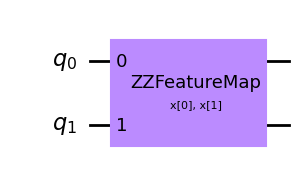

In [54]:
# Define a (non-parameterized) feature map from the Qiskit circuit library
fm = ZZFeatureMap(2)
input_params = fm.parameters
fm.draw('mpl')

Let's partition the input parameters into two sets such that the second one is reassigned to be a user (trainable) parameter:

In [55]:
# split params into two disjoint sets
input_params = fm.parameters[::2]
training_params = fm.parameters[1::2]
print("input_params:", input_params)
print("training_params:", training_params)

input_params: [ParameterVectorElement(x[0])]
training_params: [ParameterVectorElement(x[1])]


For clarity, we will manually reassign the feature map parameters such that the new parameters are properly named. (Renaming is not strictly required in this example; however, in the example below it will be necessary to prevent name collisions.)

input_params: x, ['x[0]']
training_params: θ, ['θ[0]']


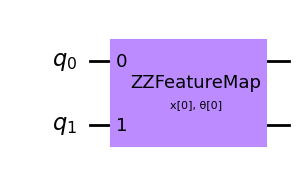

In [56]:
# define new parameter vectors for the input and user parameters
new_input_params = ParameterVector("x", len(input_params))
new_training_params = ParameterVector("θ", len(training_params))

# resassign the origin feature map parameters
param_reassignments = {}
for i, p in enumerate(input_params):
    param_reassignments[p] = new_input_params[i]
for i, p in enumerate(training_params):
    param_reassignments[p] = new_training_params[i]

fm.assign_parameters(param_reassignments, inplace=True)

input_params = new_input_params
training_params = new_training_params

print("input_params:", input_params)
print("training_params:", training_params)
fm.draw('mpl')

### Option 2: Compose Multiple Circuits

We can build a parameterized feature map out of existing Qiskit library circuits by composing them to form a larger composite circuit. However, if two circuits have (different) parameters that share the same name, Qiskit will not allow us to compose them. 

To resolve this issue, we will simply rename our user parameters to prevent name collisions. As a nice side effect, our parameter names will also be more accurate and helpful. Again, note that our parameter names are automatically updated in our feature map circuit.

*Note: although both options we show in this guide use two qubits, Option 2 results in a feature map that accepts two-dimensional data while Option 1 results in a feature map for one-dimensional data.*

input_params: [ParameterVectorElement(x[0]), ParameterVectorElement(x[1])]
training_params: θ, ['θ[0]', 'θ[1]']


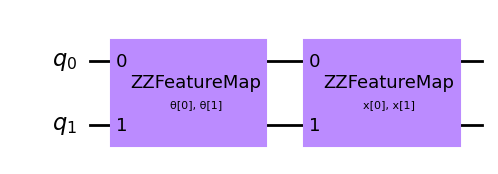

In [57]:
# Define two circuits
circ1 = ZZFeatureMap(2)
circ2 = ZZFeatureMap(2)
input_params = circ1.parameters
training_params = ParameterVector("θ", 2)

# Reassign new parameters to circ2 so there are no name collisions
circ2.assign_parameters(training_params, inplace=True)

# Compose to build a parameterized feature map
fm = circ2.compose(circ1)
print("input_params:", list(input_params))
print("training_params:", training_params)
fm.draw('mpl')